# Malaria Cell Classification: Results Visualization

This notebook demonstrates advanced visualization and analysis techniques for a deep learning-based malaria cell classification project. The workflow highlights robust data handling, modular code design, and state-of-the-art embedding visualizations, showcasing my ability to deliver professional, maintainable, and insightful machine learning solutions.

We will:
- Load your trained model and data
- Extract and visualize embeddings
- Calculate the sensitivity and the specificity of this model
- Explore training metrics and dimensionality reduction plots

In [1]:
# Import required libraries and project modules
import os
import warnings

import torch

os.chdir("../")


from malaria.data import MalariaDataModule
from malaria.utils import EmbeddingVisualizer
from malaria.yolo.model import YOLOLitModel

# Set Up Plot Saving Directory
Set the global variable to control whether plots are saved and where.

## Data and Model Loading

All data and model loading is handled in a reproducible and modular fashion. Paths and hyperparameters are clearly defined for easy adaptation and extension. This section demonstrates best practices for experiment setup in a research or production environment.

In [4]:
# Set paths and hyperparameters (edit as needed)
DATA_DIR = "dataset"
MODEL_PATH = "lightning_logs/yolo/yolo11n-cls/version_0/checkpoints/last.ckpt"
LOG_DIR = "lightning_logs/yolo/yolo11n-cls/version_0"
BATCH_SIZE = 32

# Set to None to disable saving, or to a directory path to enable
SAVE_PLOTS_DIR = "results/yolo11n-cls/visualization"
os.makedirs(SAVE_PLOTS_DIR, exist_ok=True) if SAVE_PLOTS_DIR else None


In [5]:
# Load data and model

# Initialize and set up the data module
data_module = MalariaDataModule(data_dir=DATA_DIR, batch_size=BATCH_SIZE)
data_module.setup()
train_loader = data_module.train_dataloader()

# Load model from checkpoint
model = YOLOLitModel()
checkpoint = torch.load(MODEL_PATH, map_location="cpu")
if "state_dict" in checkpoint:
    model.load_state_dict(checkpoint["state_dict"])
else:
    model.load_state_dict(checkpoint)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Visualize Results and Quantitative Evaluation

This section demonstrates how to visualize the model's training process and results using the provided utility functions, and how to quantitatively evaluate the model using sensitivity and specificity. These metrics are especially important in medical machine learning projects, where both visual and quantitative analysis are required for a robust assessment.

## Embedding Extraction

This section extracts high-dimensional embeddings from the trained model, leveraging modular utility classes for maintainability and scalability. The approach enables in-depth analysis of learned feature spaces and supports a variety of downstream visualizations.

Embeddings are compact, high-dimensional vector representations of input data (such as images or text) learned by a neural network. In the context of malaria cell classification, embeddings capture the essential features of cell images that the model uses to distinguish between classes (e.g., infected vs. uninfected).

Extracting embeddings involves passing the dataset through the trained model and collecting the output from an intermediate layer (typically before the final classification layer). These embeddings can then be visualized or analyzed using dimensionality reduction techniques (like t-SNE, UMAP, or PCA) to gain insights into how the model organizes and separates different classes in its learned feature space.

In [6]:
# Create EmbeddingVisualizer instance and extract embeddings
visualizer = EmbeddingVisualizer(model, train_loader, device)
visualizer.extract_embeddings()  # This may take some time depending on the dataset size


(array([[     0.9996,  0.00039783],
        [ 1.3911e-05,     0.99999],
        [ 1.8574e-07,           1],
        ...,
        [ 0.00018682,     0.99981],
        [    0.94902,    0.050976],
        [    0.99999,  1.3772e-05]], shape=(17636, 2), dtype=float32),
 array([0, 1, 1, ..., 1, 0, 0], shape=(17636,)))

## Training Metrics Visualization

Training and validation metrics are visualized to provide a transparent view of model convergence, generalization, and potential overfitting. This section demonstrates the use of automated logging and robust plotting utilities for experiment tracking.

**Accuracy** measures the proportion of correct predictions made by the model out of all predictions. In the training process, training accuracy reflects how well the model fits the training data. In the validation process, validation accuracy indicates how well the model generalizes to unseen data.

**Loss** quantifies the difference between the model's predictions and the actual target values. During training, training loss shows how well the model is learning from the training data. Validation loss, calculated on a separate validation set, helps monitor whether the model is overfitting (memorizing training data) or underfitting (failing to capture patterns). Lower loss values generally indicate better model performance.

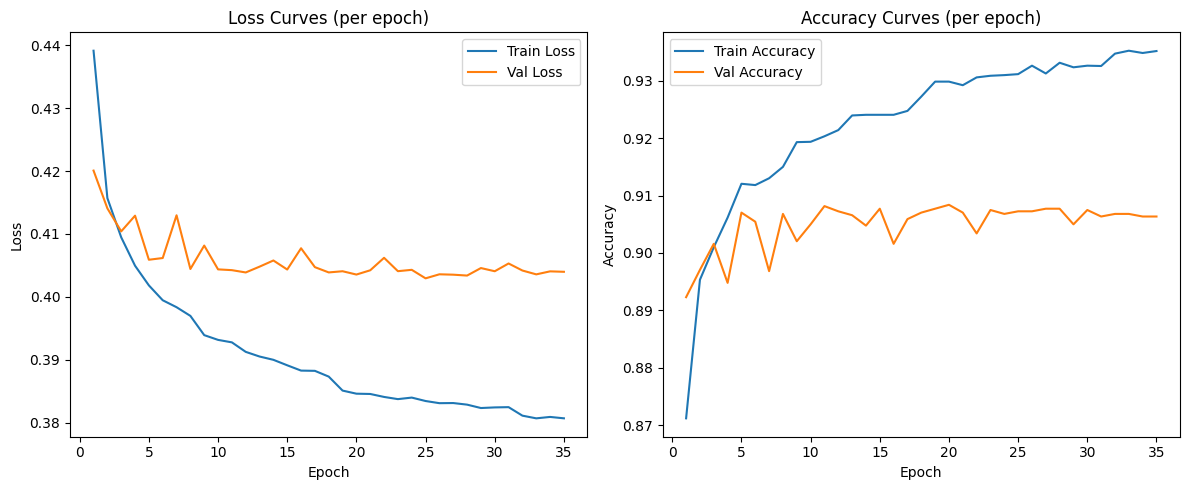

In [7]:
# Plot training and validation metrics
if SAVE_PLOTS_DIR:
    # Save plots to the specified directory
    train_path = os.path.join(SAVE_PLOTS_DIR, "train_metrics.png")
else:
    train_path = None
EmbeddingVisualizer.plot_training_metrics(LOG_DIR, save_path=train_path)  # Show plot inline

## Sensitivity and Specificity Analysis

Sensitivity (also called recall or true positive rate) measures the proportion of actual positives (e.g., infected cells) that are correctly identified by the model. Specificity (true negative rate) measures the proportion of actual negatives (e.g., healthy cells) that are correctly identified. 

- **Sensitivity** = TP / (TP + FN)
- **Specificity** = TN / (TN + FP)

These metrics are crucial in medical classification tasks, where the cost of false negatives (missed infections) and false positives (unnecessary treatments) can be very different. High sensitivity ensures most infected cases are detected, while high specificity ensures healthy cases are not misclassified as infected.

In [8]:
# Calculate and display sensitivity and specificity for the current model
TP, TN, FP, FN = visualizer.compute_outcome_masks(model, train_loader)

sensitivity = TP.sum() / (TP.sum() + FN.sum()) if (TP.sum() + FN.sum()) > 0 else float('nan')
specificity = TN.sum() / (TN.sum() + FP.sum()) if (TN.sum() + FP.sum()) > 0 else float('nan')

print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Sensitivity (Recall): 0.4840
Specificity: 0.5120


## t-SNE Visualization of Embeddings

t-SNE is used to project high-dimensional learned representations into two dimensions, enabling qualitative assessment of class separability and model behavior. This visualization is a key tool for diagnosing feature learning and identifying potential issues in the embedding space.

**Limitations:**  
- t-SNE is computationally intensive and can be slow on large datasets.
- The resulting plots can vary significantly with different parameter choices (such as perplexity) and random seeds.
- t-SNE primarily preserves local relationships, so distances between clusters may not reflect true relationships in the original space.
- It is not suitable for inferring global data structure or for quantitative analysis.

Despite these limitations, t-SNE remains a valuable tool for qualitative assessment of model embeddings and for gaining intuition about the learned feature space.

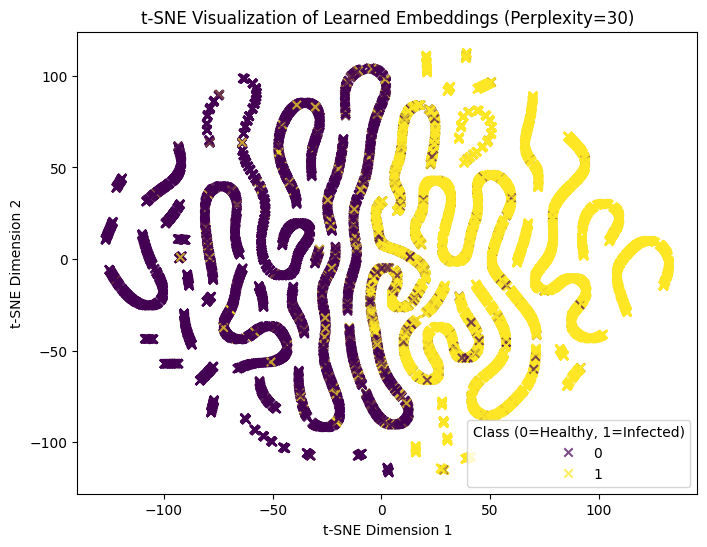

In [9]:
# Plot t-SNE visualization (colored by class)
if SAVE_PLOTS_DIR:
    tsne_path = os.path.join(SAVE_PLOTS_DIR, "tsne_class.png")
else:
    tsne_path = None
visualizer.plot_tsne(save_path=tsne_path)  # Show plot inline and/or save


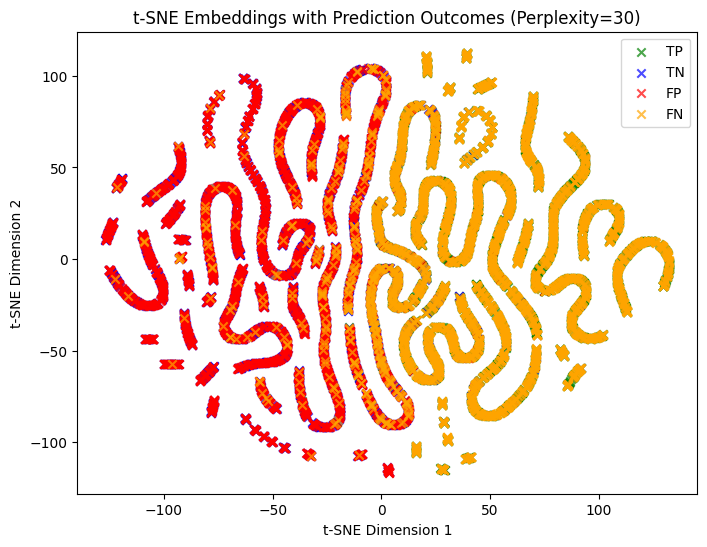

In [10]:
import os

# Plot t-SNE with prediction outcome overlays
if SAVE_PLOTS_DIR:
    tsne_outcome_path = os.path.join(SAVE_PLOTS_DIR, "tsne_outcome.png")
else:
    tsne_outcome_path = None
visualizer.plot_tsne(overlay="outcome", dataloader=train_loader, model=model, save_path=tsne_outcome_path)

## UMAP Visualization of Embeddings

UMAP provides an alternative perspective on the learned feature space, often preserving both local and global structure. This section demonstrates the flexibility of the visualization pipeline and the ability to compare multiple dimensionality reduction techniques.

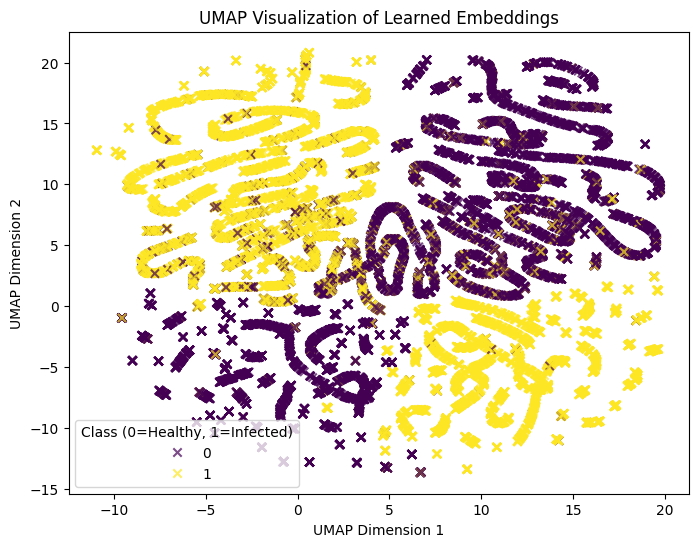

In [11]:
# UMAP visualization using EmbeddingVisualizer method (colored by class)
with warnings.catch_warnings(): # Ignore warnings from UMAP
    warnings.simplefilter("ignore")
    if SAVE_PLOTS_DIR:
        umap_class_path = os.path.join(SAVE_PLOTS_DIR, "umap_class.png")
    else:
        umap_class_path = None
    visualizer.plot_umap(save_path=umap_class_path)

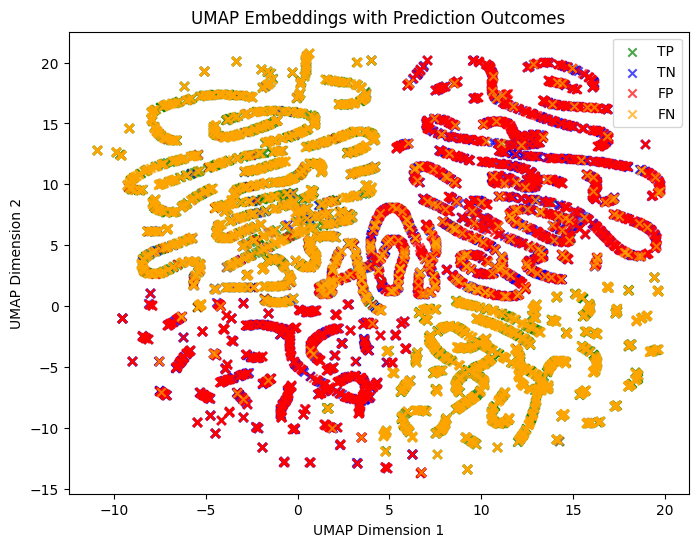

In [12]:
import os
import warnings

# UMAP visualization with prediction outcome overlays
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    if SAVE_PLOTS_DIR:
        umap_outcome_path = os.path.join(SAVE_PLOTS_DIR, "umap_outcome.png")
    else:
        umap_outcome_path = None
    visualizer.plot_umap(overlay="outcome", dataloader=train_loader, model=model, save_path=umap_outcome_path)

## PCA Visualization of Embeddings

PCA offers a linear, interpretable view of the embedding space. Including PCA in the analysis pipeline demonstrates a comprehensive approach to model evaluation, combining both linear and nonlinear techniques for a complete understanding of feature learning.

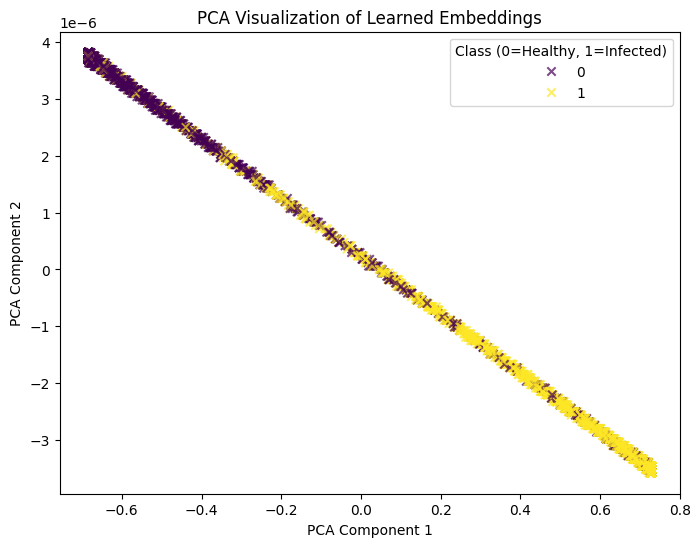

In [13]:
# PCA visualization using EmbeddingVisualizer method (colored by class)
if SAVE_PLOTS_DIR:
    pca_class_path = os.path.join(SAVE_PLOTS_DIR, "pca_class.png")
else:
    pca_class_path = None
visualizer.plot_pca(save_path=pca_class_path)

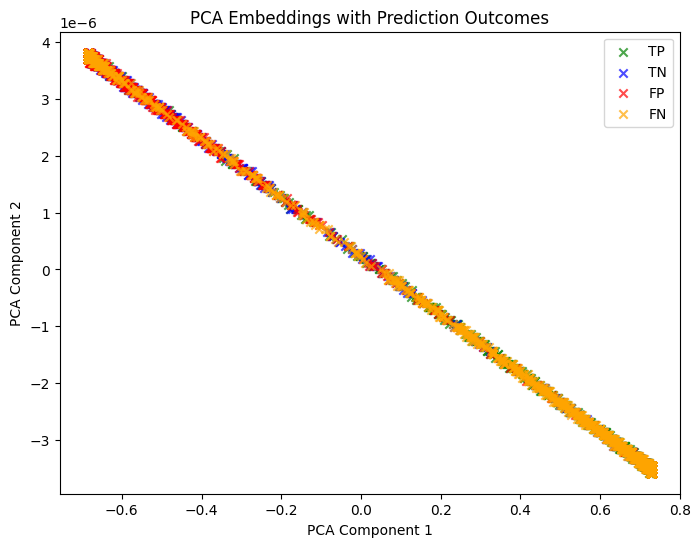

In [14]:
# PCA with prediction outcomes using EmbeddingVisualizer method
if SAVE_PLOTS_DIR:
    pca_outcome_path = os.path.join(SAVE_PLOTS_DIR, "pca_outcome.png")
else:
    pca_outcome_path = None
visualizer.plot_pca(overlay="outcome", dataloader=train_loader, model=model, save_path=pca_outcome_path)

---

## Summary

This notebook showcases:
- Modular, maintainable code for deep learning experiment analysis
- Advanced visualization of learned representations using t-SNE, UMAP, and PCA
- Automated experiment tracking and robust metric visualization
- Quantitative evaluation of model performance using sensitivity and specificity, critical for medical AI
- A professional, extensible workflow suitable for both research and production

These results reflect a commitment to best practices in machine learning engineering and scientific analysis.